# A full working example: an AGIR study of coked zeolites

This example concerns the **study of coked hierarchical zeolites**.

This notebook however focuses on the processing step we have used for this work, as well as some details about the use of the **SpectroChemPy** python package.

Fisrt, and this will be done at the top of each notebook in the tutorial, we load the **SpectroChemPy** API. It will expose all available methods that can act on `projects` and `datasets`.

In [1]:
from spectrochempy import *
preferences.log_level=WARNING

SpectroChemPy's API - v.0.1a8.dev0+gbdf190e8.d20171230
© Copyright 2014-2017 - A.Travert and C.Fernandez @ LCS


## Introduction

The AGIR instrument setup is displayed in the following figure. 

![fig_agir_setup](annotated_fig_agir_setup.jpg)

This instrument consists in the cmbination of an infrared cell and a balance. It allows recording *operando* IR spectra and, simultaneously, the mass of the sample.

## Managing the data in a project and subprojects

The data, we will be processing in this tutorial, come from the AGIR setup at the Laboratory LCS.

We have TGA (Thermogravimetric analysis) and FTIR (Fourier Transform InfraRed spectroscopy) data for 3 samples, which have been recorded simultaneously at 350 °C (623 K) under reaction with methanol:

* P (parent zeolite sample), 
* A (subjected to an acid treatment), 
* B (subjected to a basic treatment).

We know that some of the bands that develop on the IR spectra are mainly due to an increase of the coke deposits, and correspond to an increase of the mass of the pellet. This mass is recorded.

In this work we will try to correlate those evolutions of IR bands and mass of the deposits.

To manage all the data for three samples easily, we will create a *project*.

For this we can use the ``Project manager`` included in SpectroChemPy.

First we create a main project containing three sub-projects, one for each sample. A project need at least a project name (*e.g.*, the name of the sample) but if if it is not provided, some automatic title will be generated.

Some metadata can be also added at this stage or later, for example here, we add for each project a `Latex` formatted string that will serve as a label for the plot of the data. In the same way other useful metadata could be added, *e.g.*, a description of the project, etc.

The actual TG and IR data will be added later.

In [2]:
proj = Project(
                Project(name='P350', label=r'$\mathrm{M_P\,(623\,K)}$'),
                Project(name='A350', label=r'$\mathrm{M_A\,(623\,K)}$'),
                Project(name='B350', label=r'$\mathrm{M_B\,(623\,K)}$'),
                name = 'HIZECOKE',
              )

Display the structure of this project

In [3]:
proj

We can access the content and attributes of a Project object using 2 syntax. One is the following (wich works only if the name of the object doesn't contain any space, dash, dot, or other non alphanumeric characters, excepted the underscore "`_`". Also, do not start a name with a number.):

In [4]:
label = proj.P350.label
label

'$\\mathrm{M_P\\,(623\\,K)}$'

As the label is a latex string, we can use the `Latex` command get a pretty output of the latex content of this label

In [5]:
Latex(label)  # note that this work only on the real jupyter notebook (not in the HTML documentation)

<IPython.core.display.Latex object>

If the above syntax doesn't work (e.g., it the name contains space), we can always access using keys (Project are actually behaving mainly as python dictionaries)

In [6]:
Latex(proj['P350'].label)

<IPython.core.display.Latex object>

## Reading the experimental data

The IR data have been exported as `csv` file (on file per spectra) and then zipped. Therefore, we will use the function `read_zip` to open the IR data. 

For the TGA data are in `csv` files, so we use `read_csv` to read them.

### Reading the raw  IR data

Note that reading a large set of `.csv` file is rather slow. Be patient! 

After reading each dataset, we save the data in the `scp` format of SpectroChemPy, so that any further reading of the data will be much faster.

For this tutorial, the experimental data ate stored in a example directory, accessed here through, the variable `datadir.path`. As we have to  reaping the same kind of reading three times, let's write a small reading function: 

In [7]:
def readIR(name, force_read_original=False):
    
    # Our data are in our test `datadir.path` directory. 
    # Here is the full path (depending on name) without the file extension:
    basename = os.path.join(datadir.path,'agirdata/{}/FTIR/FTIR'.format(name))
    
    # Check first if a `.scp` file have already been saved.
    # This happens if this not the first time we are executing this notebook.
    # If it exists we will use this file which is much faster to read.
    if os.path.exists(basename+'.scp') and not force_read_original:
        # A `.scp` file allready exists, use this one (except if the flag
        # `force_read_original` is set):
        filename = basename + '.scp'
        # we use the generic `read` method of the class NDDataset 
        # to read this file and create a new dataset.
        dataset = NDDataset.read( filename)
        
    else:
        # This is the first time we execute this function, 
        # then we read the original `.zip` file
        filename = basename + '.zip'
        # to read it, we use the `read_zip` method:
        dataset = NDDataset.read_zip( filename, origin='omnic_export')
        # to accelerate the process next time, we save this dataset 
        # in a `scp` format
        dataset.save(basename + '.scp')
        
    return dataset

Ok, now we use this function to read the 3 FTIR file and we add them to the corresponding sub-project of our project

The list of names of the subprojects is accessible in the property `projects_names` of the dataset.

In [8]:
for name in proj.projects_names:
    # read the corresponding dataset
    dataset = readIR(name, force_read_original=False)
    # add it to the corresponding sub-project. We can access directy using its name
    # NOTE: all names of objects contained in a given project 
    # must be unique for this to work!
    # Last thing. because the name of the Dataset is not very informative 
    # we give explicitely a name for the entry in the subproject
    proj[name].add_dataset(dataset, name='IR')

Display the updated structure of the project:

In [9]:
proj

### Plot of the raw IR data 

We will select here only the datasets we want to plot and the correspondings labels

In [10]:
datasets =[]
labels = []
for p in proj.projects:
    datasets.append(p.IR)
    labels.append(p.label)   

Now we call this multiplot to plots the datasets in row. Note the use of sharez, because the vertical axis here is z (the intensity) and not y (which refer to the evolution). Note: this method return the contained axes in the figure. So to avoid their display in the iutput we affect them to some variables, e.g., "`_`" which means that we do not want to keep the results

<IPython.core.display.Javascript object>


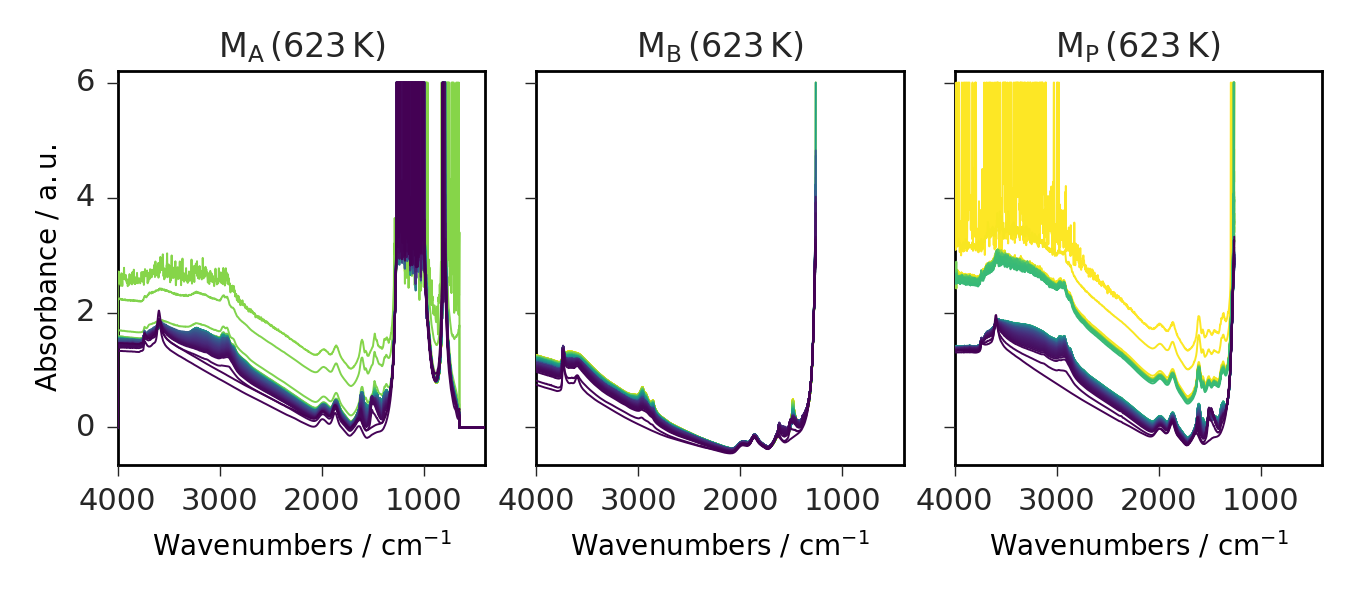

In [11]:
_ = multiplot_stack(sources=datasets, labels=labels, 
                nrow=1, ncol=3, sharex=False, sharez=True, 
                figsize=(6.8,3), dpi=100, style='sans')

May be to analyse more easily the y dimension, map plot would be better. 

Let's then plot the data using this plot method (plot method: `map` instead of `stack`)

<IPython.core.display.Javascript object>


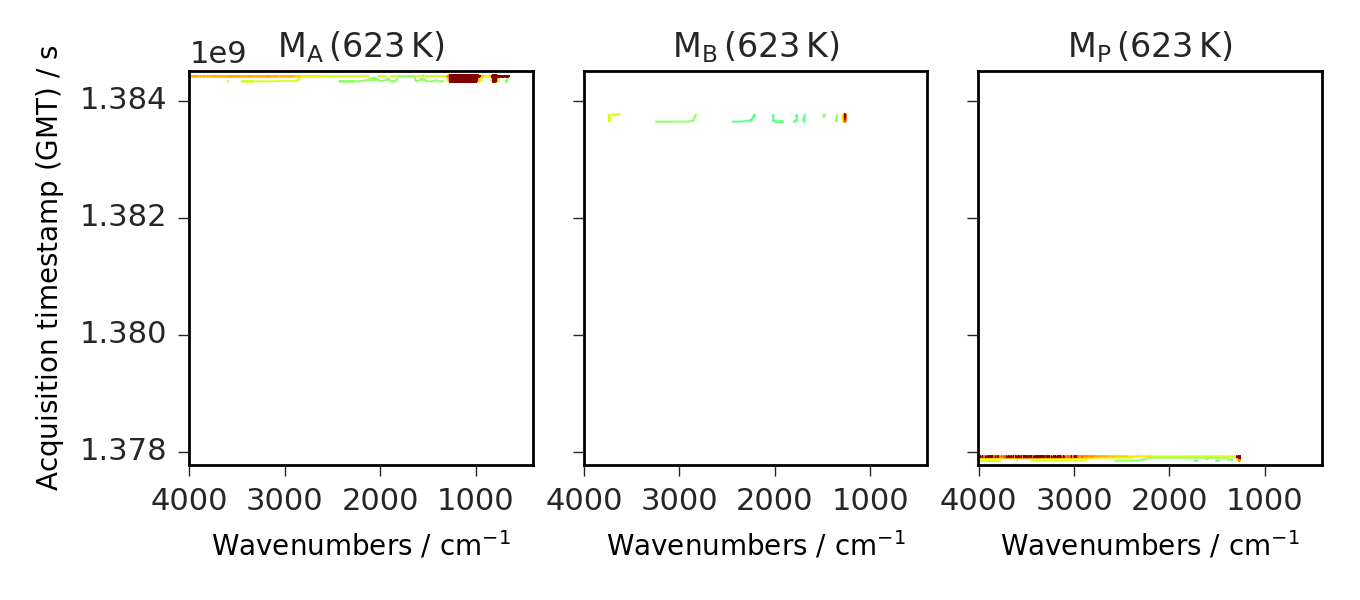

In [12]:
_ = multiplot_map(sources=datasets, labels=labels, 
                nrow=1, ncol=3, sharex=False, sharey=True, 
                figsize=(6.8,3), dpi=100, style='sans')

Hum? this is not very nice, because the y scale being the timestamps (the time from some reference date of the acquisition of the data), they cannot be easily compared.

Let's take a comon origin (and express the units in hours instead of seconds)!

In [13]:
for ds in datasets:
    ds.y -= ds.y[0]    # remove the timestamp offset from the axe y
    ds.y.ito('hour')   # adapt units to the length of the acquisition 
                       # for a prettier display
    ds.y.title = 'Time-on-stream' 
                       # put some explicit title (to replace timestamps)

Now we replot the data:

<IPython.core.display.Javascript object>


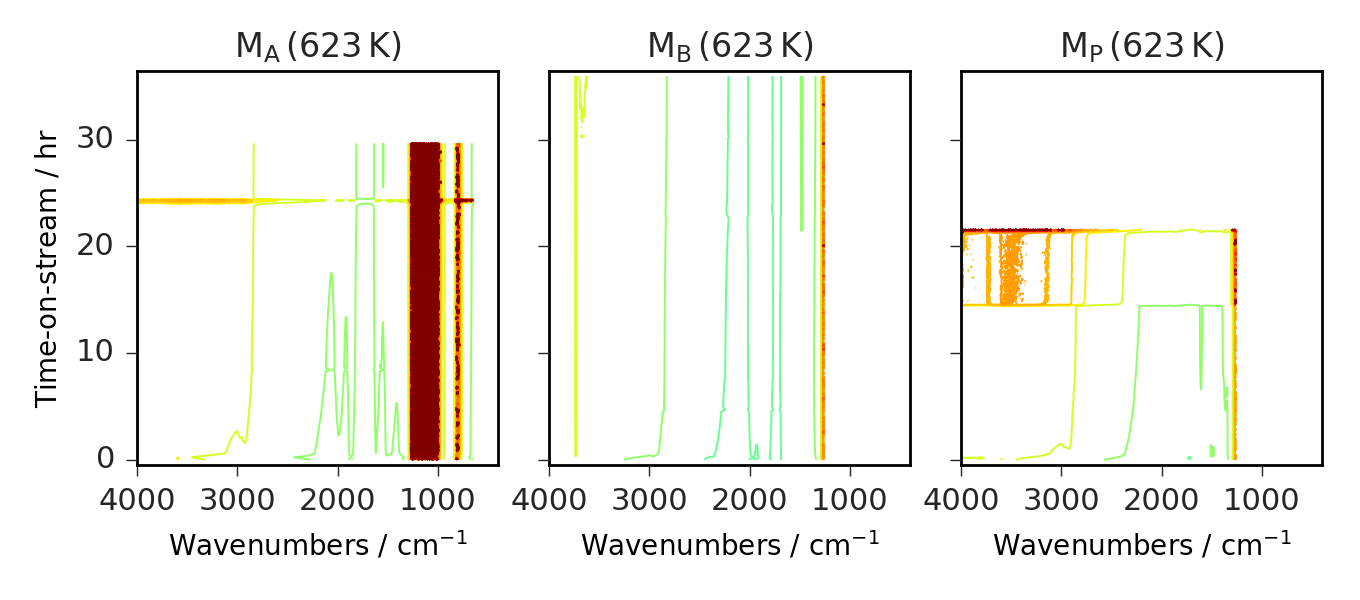

In [14]:
_ = multiplot_map(sources=datasets, labels=labels, 
                nrow=1, ncol=3, sharex=False, sharey=True, 
                figsize=(6.8,3), dpi=100, style='sans')

This is much better!

### Reading the raw TGA data

Now read the TGA data. And again we will create a reading function to apply to the 3 samples.

In [15]:
def readTGA(name, force_read_original=False):
    basename = os.path.join(datadir.path,'agirdata/{}/TGA/tg'.format(name))
    if os.path.exists(basename+'.scp') and not force_read_original:
        # check if the scp file have already been saved
        filename = basename + '.scp'
        dataset = NDDataset.read( filename)
    else:
        # else read the original csv file
        filename = basename + '.csv'
        dataset = NDDataset.read_csv(filename)
        dataset.save(basename + '.scp')
    return dataset

Now we read the TGA datasets and add them to our current project

In [16]:
for name in proj.projects_names:
    # read the corresponding dataset
    dataset = readTGA(name, force_read_original=False)
    # add it to the corresponding sub-project. 
    proj[name].add_dataset(dataset, name='TGA')

Display the updated structure:

In [17]:
proj

### Plot of the raw TGA data

Let's plot the 3 1D TGA datasets on the same figure.

In [18]:
tga_datasets =[]
for p in proj.projects:
    tga_datasets.append(p.TGA) 

<IPython.core.display.Javascript object>


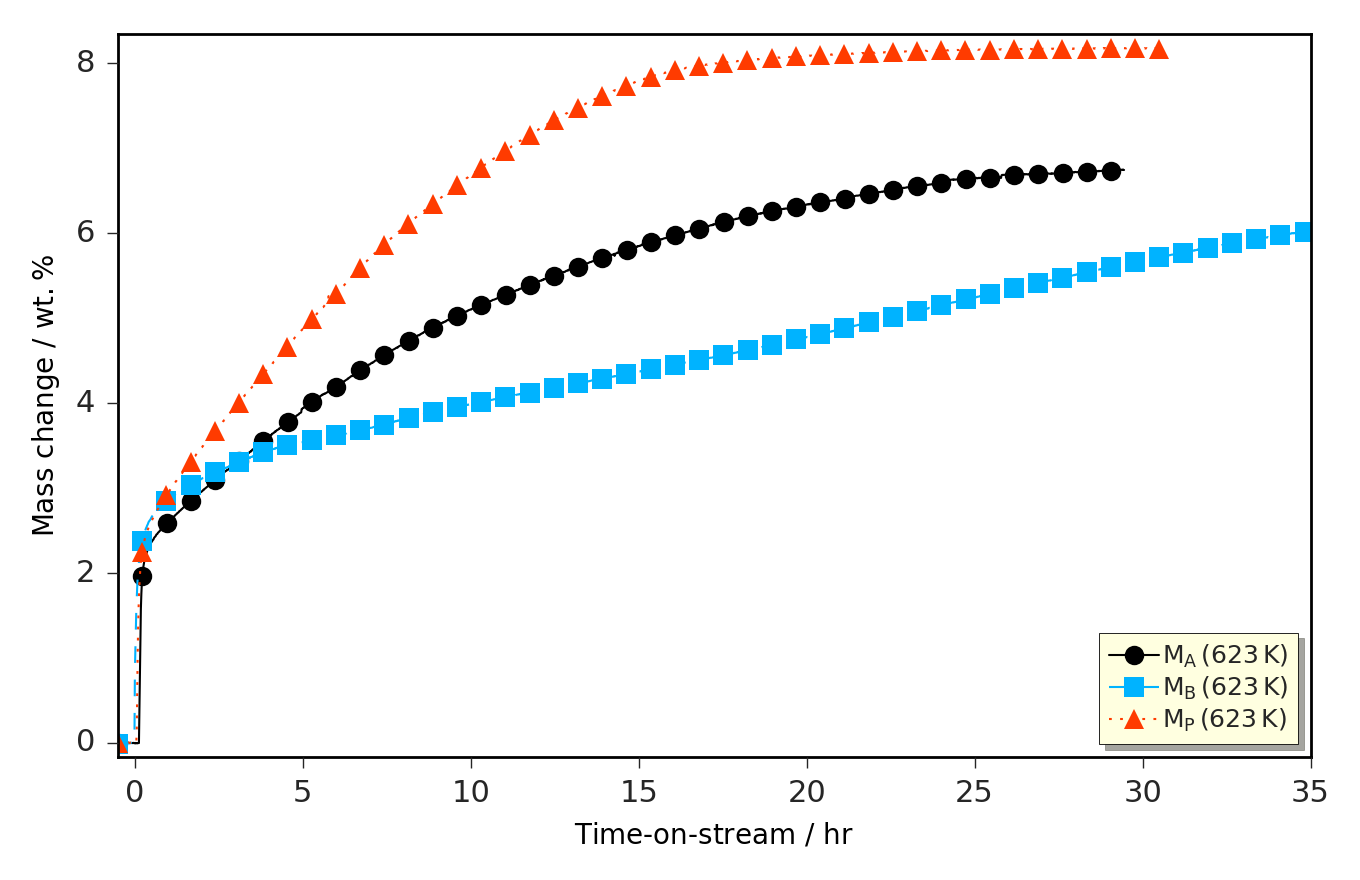

In [19]:
_ = plot_multiple(sources=tga_datasets, labels=labels, lines=True, style='sans', 
                  markevery=50, markersize=7,
                  legend='lower right')

Some information on this data are not present in the csv files used, so we need to add them now, to get better plots (also some part of the data, *e.g.*, before time 0, are not very useful and will be removed)

In [20]:
for tgads in tga_datasets:       
    tgads = tgads[-0.5:35.0]          # keep only useful range. 
                                       # Note the slicing by location
    tgads.x.units = 'hour'             # x dimension units
    tgads.units = 'weight_percent'     # data units
    tgads.x.title = 'Time-on-stream'   # x title information for labeling
    tgads.title = 'Mass change'        # data title information for labeling

 WARNING | SpectroChemPyWarning:  This coordinate (-0.5) is outside the axis limits (-0.494659132-29.44875667).
The closest limit index is returned
 WARNING | SpectroChemPyWarning:  This coordinate (35.0) is outside the axis limits (-0.494659132-29.44875667).
The closest limit index is returned
 WARNING | SpectroChemPyWarning:  This coordinate (-0.5) is outside the axis limits (-0.499333434-34.9945012).
The closest limit index is returned
 WARNING | SpectroChemPyWarning:  This coordinate (35.0) is outside the axis limits (-0.499333434-34.9945012).
The closest limit index is returned
 WARNING | SpectroChemPyWarning:  This coordinate (35.0) is outside the axis limits (-0.502332899-30.66650174).
The closest limit index is returned


We get some warnings because the axis range is too high for two of the dataset. We can safely ignore this.

Note that we can easily remove such warnings by changing the loglevel temporarilly:

In [21]:
preferences.log_level = ERROR

for tgads in tga_datasets:       
    tgads = tgads[-0.5:35.0]          
    tgads.x.units = 'hour'            
    tgads.units = 'weight_percent'    
    tgads.x.title = 'Time-on-stream'  
    tgads.title = 'Mass change'        
    
preferences.log_level = WARNING

Let's now plot the data again:

<IPython.core.display.Javascript object>


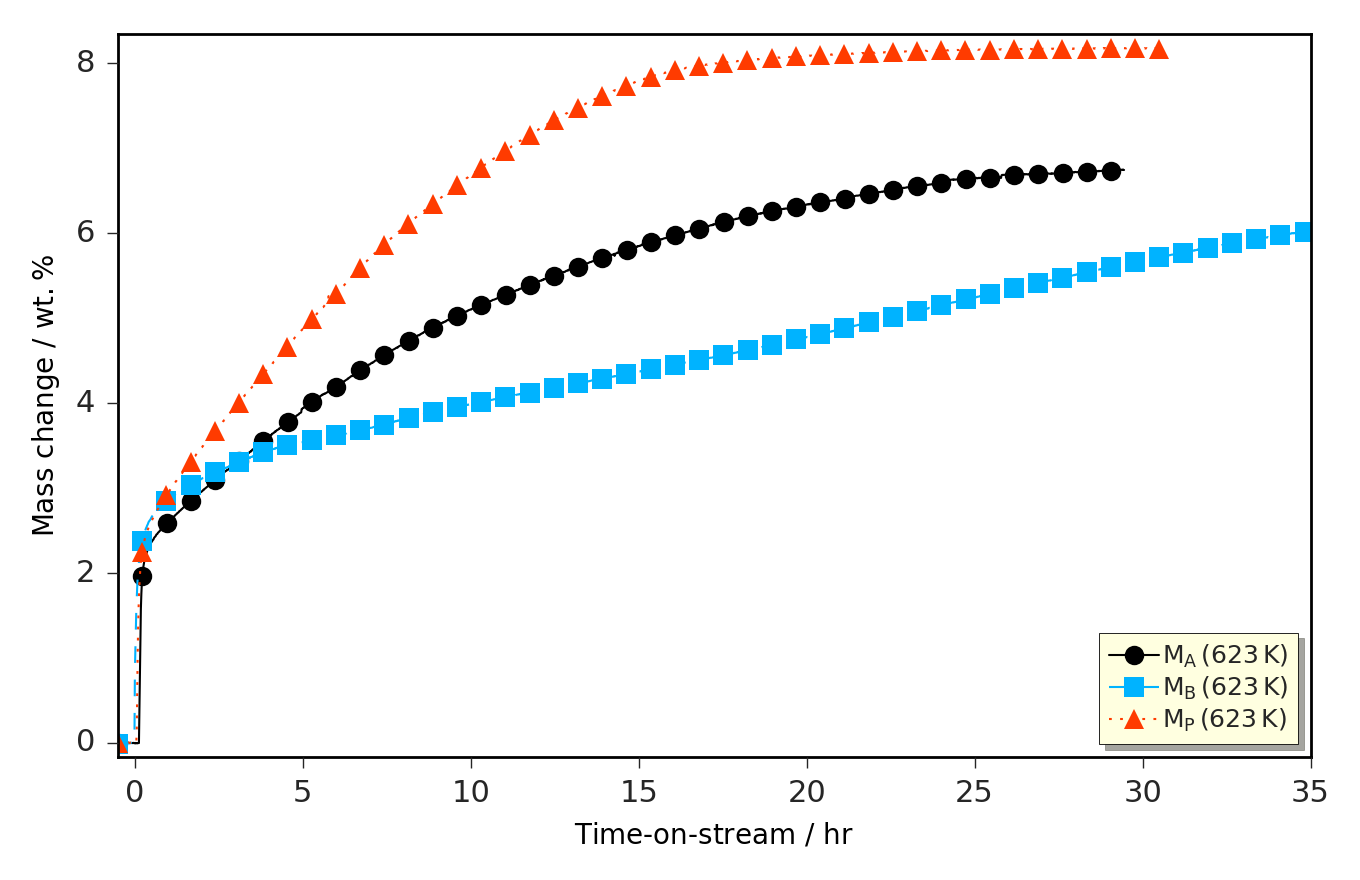

In [22]:
_ = plot_multiple(sources=tga_datasets, labels=labels, lines=True, style='sans', markevery=50, markersize=7,
                  legend='lower right')

**Why nothing has changed?**

Simply because when we have done the slicing we have actually created a copy of the initial object 
before doing the slicing. So the original object has not been changed, but the copy!

**How to solve this problem ?**

We need to do the slicing in place and for this just put the constant **INPLACE** in the slicing indications.

<IPython.core.display.Javascript object>


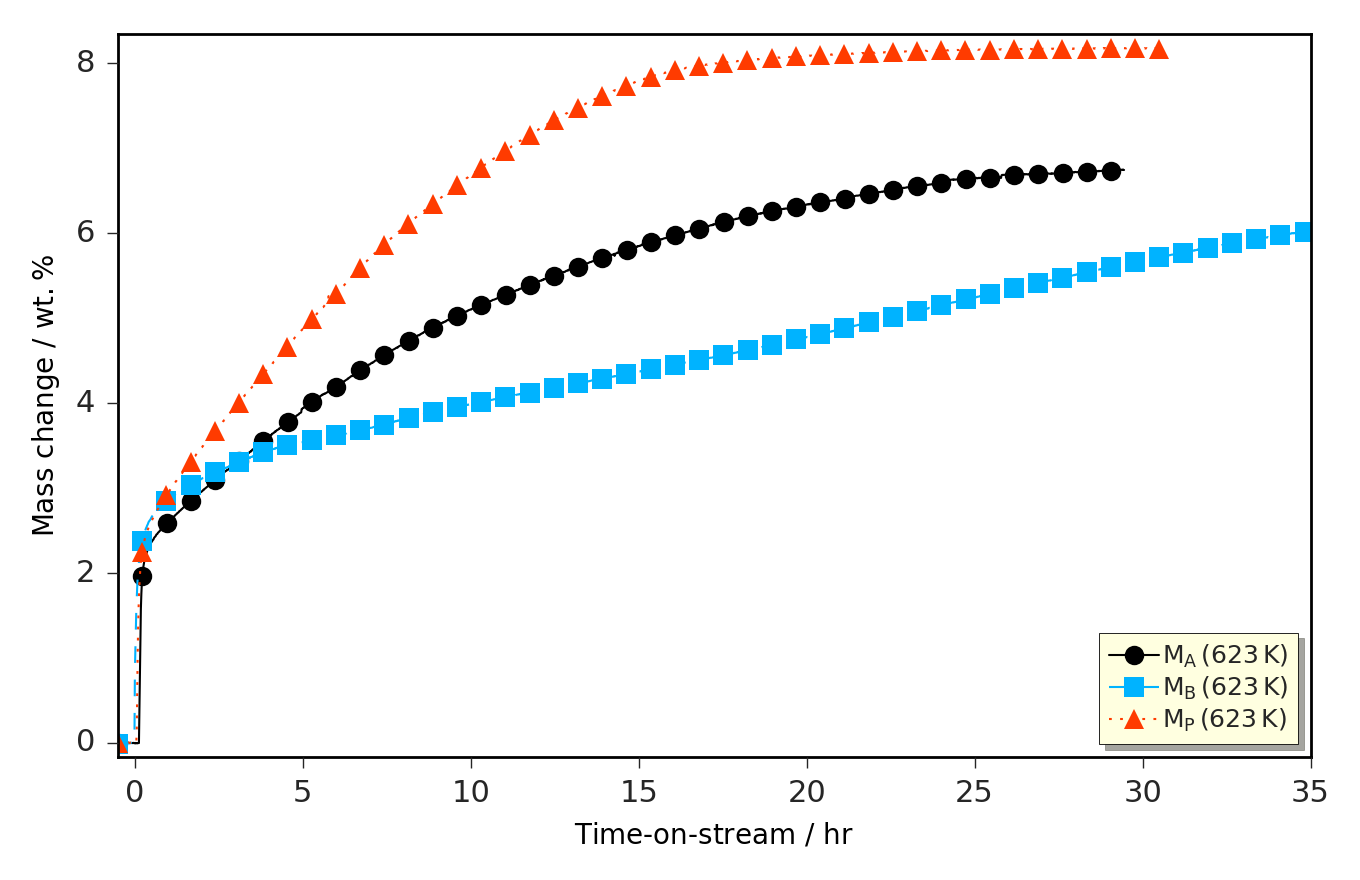

In [23]:
preferences.log_level = ERROR
    
for tgads in tga_datasets:       
    tgads[-0.5:35.0, INPLACE]          # keep only useful range. Note the slicing by location
                                       # NOTE: the INPLACE addition!
    tgads.x.units = 'hour'             # x dimension units
    tgads.units = 'weight_percent'     # data units
    tgads.x.title = 'Time-on-stream'   # x title information for labeling
    tgads.title = 'Mass change'        # data title information for labeling
    
preferences.log_level = WARNING

_ = plot_multiple(sources=tga_datasets, labels=labels, lines=True, style='sans', markevery=50, markersize=7,
                  legend='lower right')

### Saving the project

Ok, we have now build our project with some data and attributes. 

If we go to another notebook, we would like to get all the data without doing again the operations made on this notebook. 

So we need to save this project.

In [24]:
proj.save('HIZECOKE')

In the next [notebook](agir_IR_processing.ipynb), we will now proceed with some basic pre-processing of the IR data, such as slicing interesting regions, and masking some data. 